In [2]:
from pathlib import Path
from typing import List, Optional
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
import shutil
import platform
from tqdm import tqdm
import os
import sys
import shutil
import subprocess
import random
from typing import List, Tuple, Any, Optional, Literal, Dict, Union, TypedDict
from pathlib import Path
import json
import re
from collections import Counter, defaultdict
import logging
import numpy as np
import multiprocessing as mp
from multiprocessing import Pool
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile
import matplotlib.font_manager as fm

import matplotlib as mpl
from matplotlib.patches import Patch

font_path = "/System/Library/Fonts/Supplemental/Times New Roman.ttf"

times_new_roman = fm.FontProperties(fname=font_path, size=18)
prop = fm.FontProperties(fname=font_path, size=18)
# Apply globally via rcParams
plt.rcParams['font.family'] = times_new_roman.get_name()


# # Draw a nested boxplot to show bills by day and time
# plt.figure(figsize=(10, 3))  # width=10, height=6 inches
sns.set(style="whitegrid")  # Clean background
sns.set(rc={
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 18,
    "font.size": 18,
    "figure.dpi": 300,
    "savefig.dpi": 300
})
sns.set_context("paper", font_scale=1)

palette = sns.color_palette("Set2")  # Or "muted", "colorblind", etc.

mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

figsize = (6.8, 4.5)                    # best for paper print

from src.webanno_tsv import webanno_tsv_read_file, Document, Annotation, Token

train_data_dir = Path("./data/train")
test_data_dir = Path("./data/test_labeled")
val_data_dir = Path("./data/val")


In [5]:
from collections import defaultdict, Counter

def get_annotations(files):
    annotations = []
    for file_path in files:
        doc = webanno_tsv_read_file(file_path)
        annotations.extend([x for x in doc.annotations])

    print(f'{len(annotations)} annotations found in {len(files)} files.')    
    label_to_entities = defaultdict(list)
    for annotation in annotations:
        label_to_entities[annotation.label].append(annotation.text)

    total_span, total_unique_span = 0, 0
    label_to_entities = dict(sorted(label_to_entities.items()))
    for label, entities in label_to_entities.items():
        total_span += len(entities)
        print(f'{label}:\t{len(entities)}')
    print('======================')
    for label, entities in label_to_entities.items():
        unique_entities = set(entities)
        total_unique_span += len(unique_entities)
        print(f'{label}:\t{len(unique_entities)}')

    return label_to_entities, total_span, total_unique_span

In [17]:
files = [x for x in train_data_dir.rglob("*.tsv")]

_, total_train_span, total_unqiue_train_span = get_annotations(files)


7155 annotations found in 140 files.
CONFERENCE:	386
DATASET:	1174
EVALMETRIC:	403
LICENSE:	106
ONTOLOGY:	77
PROGLANG:	488
PROJECT:	656
PUBLICATION:	726
SOFTWARE:	3104
WORKSHOP:	35
CONFERENCE:	253
DATASET:	498
EVALMETRIC:	156
LICENSE:	51
ONTOLOGY:	28
PROGLANG:	59
PROJECT:	118
PUBLICATION:	578
SOFTWARE:	1067
WORKSHOP:	28


In [18]:
files = [x for x in val_data_dir.rglob("*.tsv")]

_, total_val_span, total_unqiue_val_span = get_annotations(files)

1541 annotations found in 20 files.
CONFERENCE:	365
DATASET:	159
EVALMETRIC:	58
LICENSE:	15
ONTOLOGY:	27
PROGLANG:	56
PROJECT:	77
PUBLICATION:	373
SOFTWARE:	404
WORKSHOP:	7
CONFERENCE:	116
DATASET:	56
EVALMETRIC:	35
LICENSE:	7
ONTOLOGY:	6
PROGLANG:	14
PROJECT:	19
PUBLICATION:	354
SOFTWARE:	130
WORKSHOP:	7


In [19]:
files = [x for x in test_data_dir.rglob("*.tsv")]

_, total_test_span, total_unqiue_test_span = get_annotations(files)

1995 annotations found in 40 files.
CONFERENCE:	195
DATASET:	263
EVALMETRIC:	143
LICENSE:	26
ONTOLOGY:	8
PROGLANG:	109
PROJECT:	28
PUBLICATION:	362
SOFTWARE:	824
WORKSHOP:	37
CONFERENCE:	137
DATASET:	122
EVALMETRIC:	72
LICENSE:	14
ONTOLOGY:	1
PROGLANG:	20
PROJECT:	23
PUBLICATION:	318
SOFTWARE:	275
WORKSHOP:	15


In [20]:
total_span = total_train_span + total_val_span + total_test_span
total_unique_span = total_unqiue_train_span + total_unqiue_val_span + total_unqiue_test_span
print(f'Total spans: {total_span}')
print(f'Total unique spans: {total_unique_span}')

Total spans: 10691
Total unique spans: 4577


In [12]:
train_files = [x for x in train_data_dir.rglob("*.tsv")]
val_files  = [x for x in val_data_dir.rglob("*.tsv")]
test_files = [x for x in test_data_dir.rglob("*.tsv")]
print(f'{len(train_files)} train files found.')
print(f'{len(val_files)} val files found.')
print(f'{len(test_files)} test files found.')
print(f'total {len(train_files) + len(val_files) + len(test_files)} files found.')

140 train files found.
20 val files found.
40 test files found.
total 200 files found.


## Figure 2

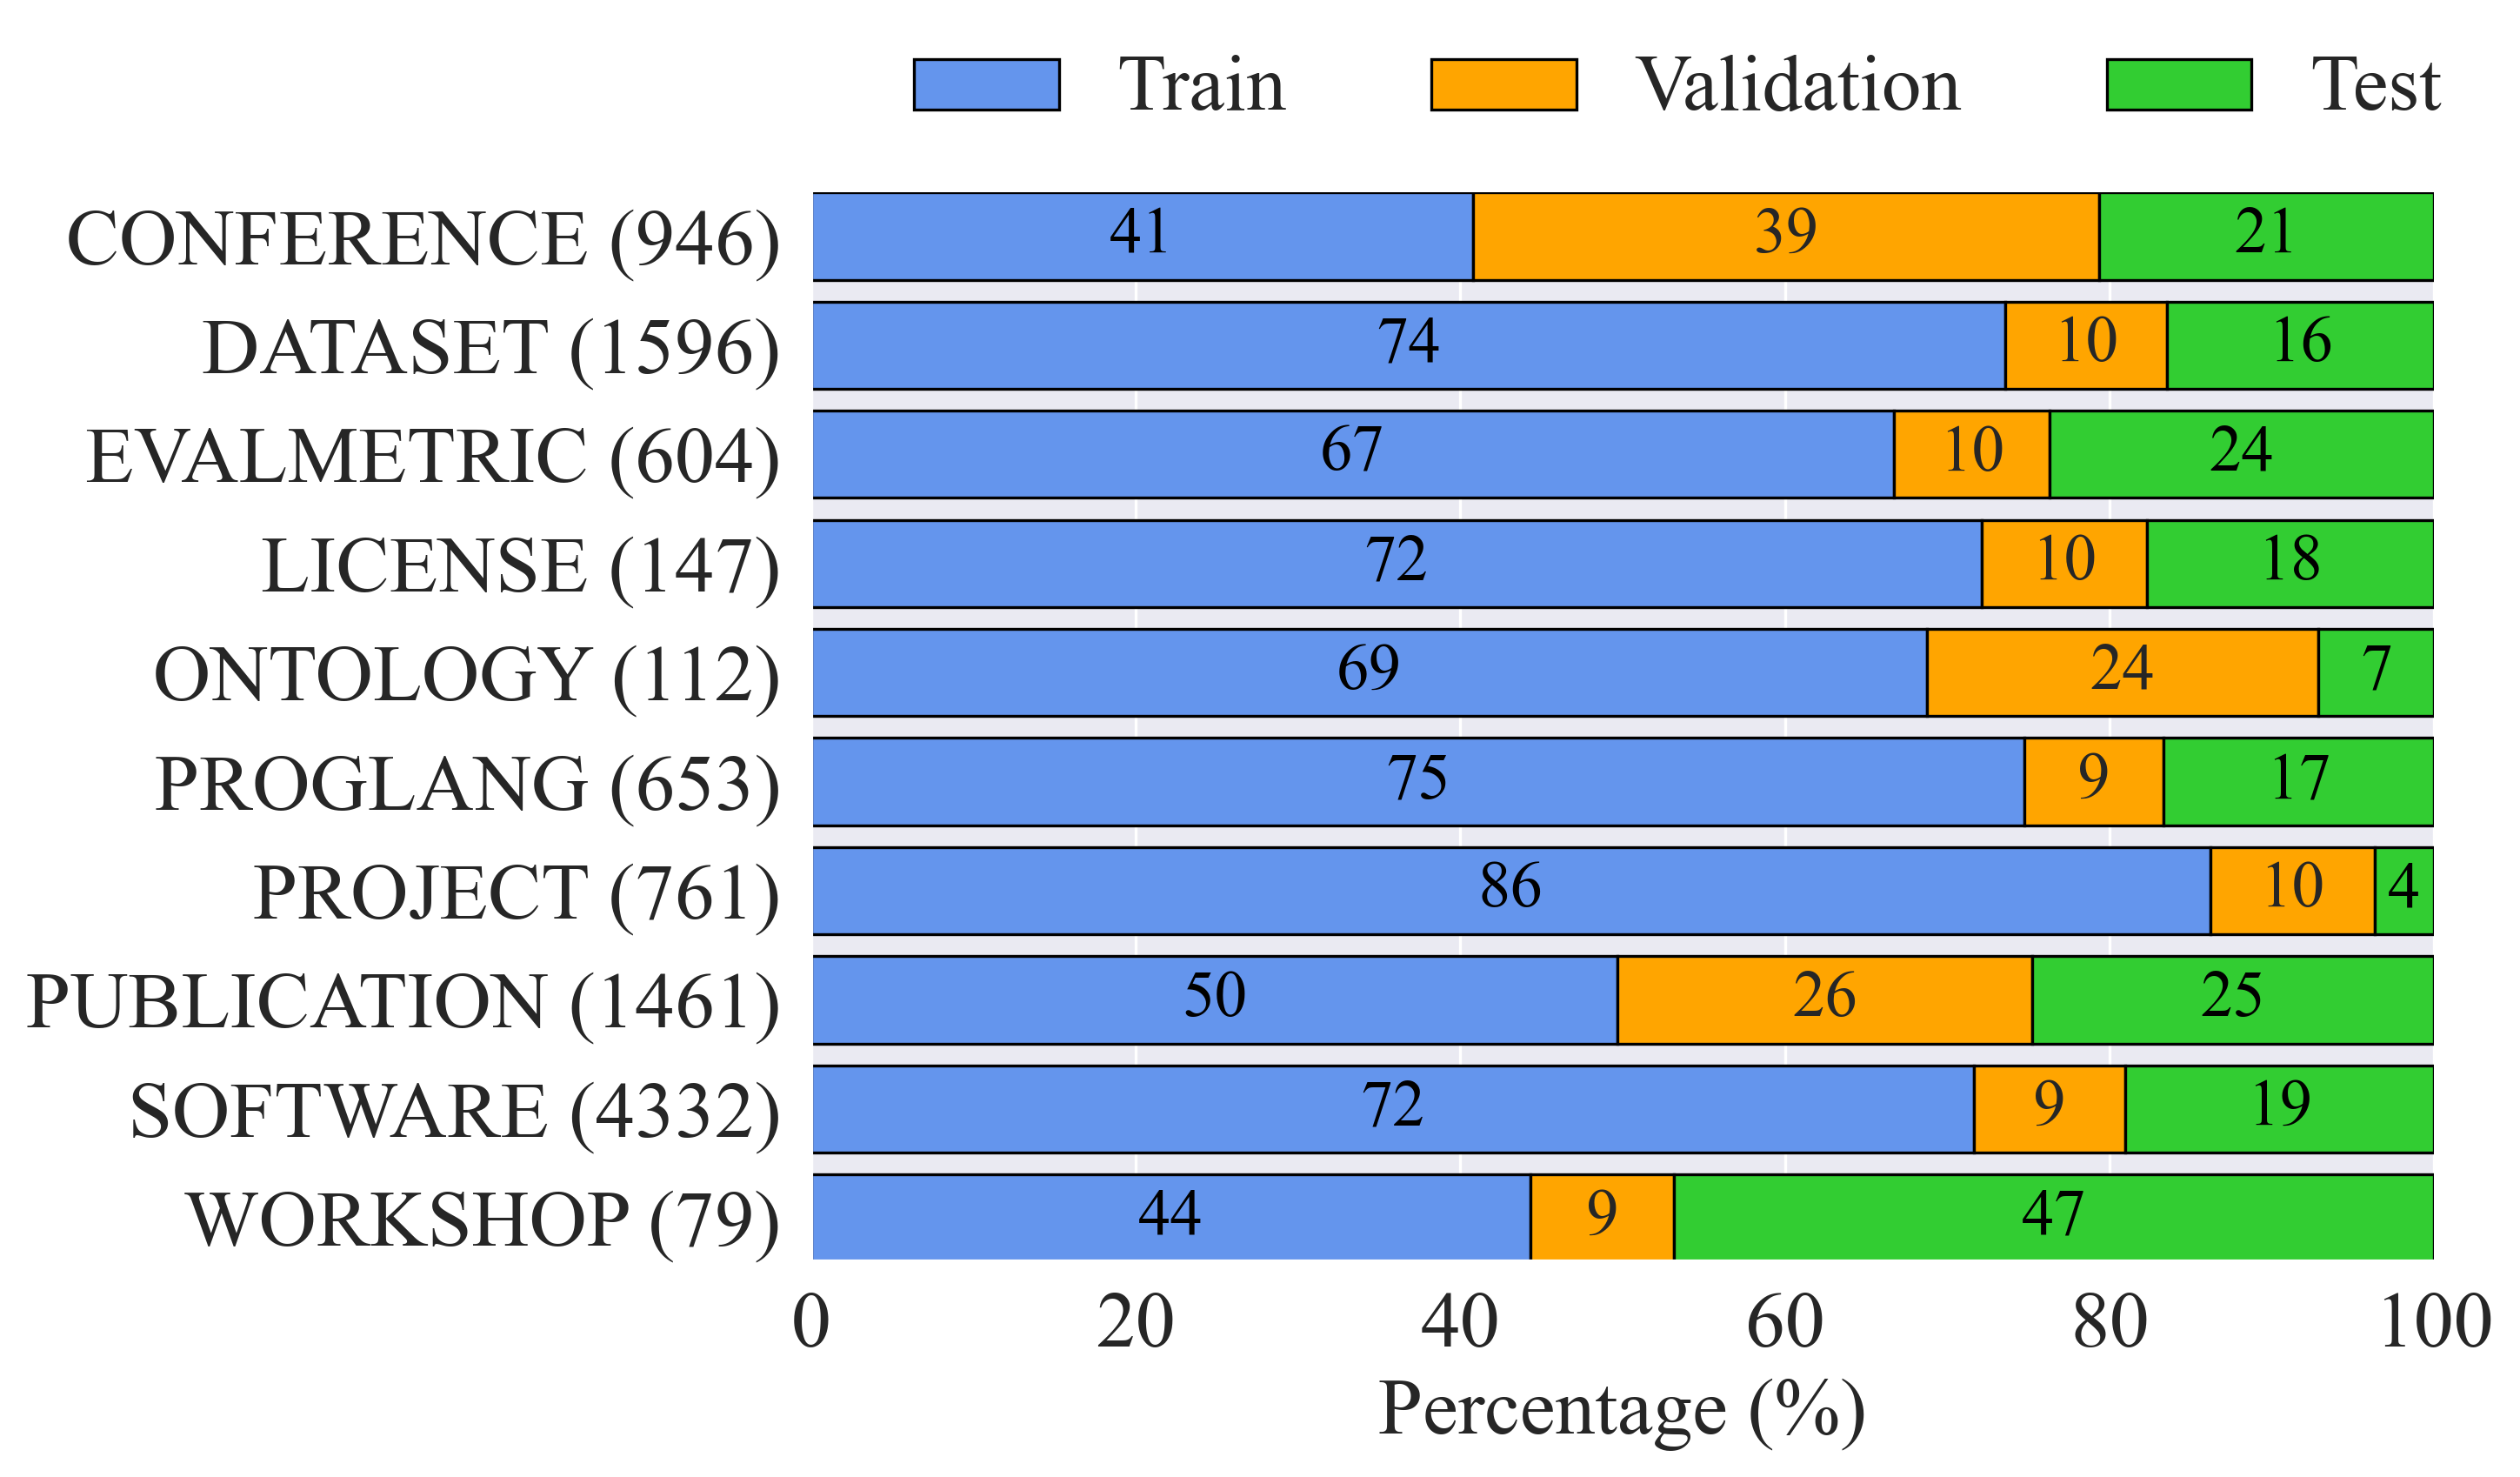

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

classes = [
    "CONFERENCE (946)", "DATASET (1596)", "EVALMETRIC (604)", "LICENSE (147)", "ONTOLOGY (112)",
    "PROGLANG (653)", "PROJECT (761)", "PUBLICATION (1461)", "SOFTWARE (4332)", "WORKSHOP (79)"
]
segments = 3

raw_values = np.array([
    [386, 365, 195],
    [1174, 159, 263],
    [403, 58, 143],
    [106, 15, 26],
    [77, 27, 8],
    [488, 56, 109],
    [656, 77, 28],
    [726, 373, 362],
    [3104, 404, 824],
    [35, 7, 37]
])

# Normalize values row-wise
values = [[v*100 / sum(row)  for v in row] for row in raw_values]

# Plot setup
fig, ax = plt.subplots(figsize=(10,6))
# fig, ax = plt.subplots(figsize=figsize)
y_pos = range(len(classes))

# Bar colors
colors = ['cornflowerblue', 'orange', 'limegreen']
# Draw stacked horizontal bars
for i, (train, val, test) in enumerate(values):
    if i == 0:
        ax.barh(i, train, color=colors[0], edgecolor='black', label='Train')
        ax.barh(i, val, left=train, color=colors[1], edgecolor='black', label='Validation')
        ax.barh(i, test, left=train + val, color=colors[2], edgecolor='black', label='Test')
    else:
        ax.barh(i, train, color=colors[0], edgecolor='black')
        ax.barh(i, val, left=train, color=colors[1], edgecolor='black')
        ax.barh(i, test, left=train + val, color=colors[2], edgecolor='black')
# Add text labels as percentages
for i, (train, val, test) in enumerate(values):
    ax.text(train / 2, i, f"{values[i][0]:.0f}", va='center', ha='center', fontsize=18, color='black', fontproperties=times_new_roman)
    ax.text(train + val / 2, i, f"{values[i][1]:.0f}", va='center', ha='center', fontsize=18, fontproperties=times_new_roman)
    ax.text(train + val + test / 2, i, f"{values[i][2]:.0f}", va='center', ha='center', fontsize=18, color='black', fontproperties=times_new_roman)

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(classes, fontsize=18)
ax.xaxis.set_visible(True)

#ax.set_xlim(0, 1)
ax.set_ylim(-0.4, len(classes)-0.6)
ax.invert_yaxis()
ax.set_xlabel('Percentage', fontsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.set_xlim(0, 100)
times_new_roman = fm.FontProperties(fname=font_path, size=18)
times_new_roman_22 = fm.FontProperties(fname=font_path, size=22)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(times_new_roman_22)
plt.xlabel('Percentage (%)', fontproperties=times_new_roman_22)

ax.legend(ncols=len(classes), 
          bbox_to_anchor=(0.023, 1),
          # bbox_to_anchor=(.01, 1),
            # loc='best',
            fontsize=20, frameon=False)

legend = ax.get_legend()
# legend.set_title(legend.get_title().get_text(), prop=times_new_roman)
for text in legend.get_texts():
    text.set_fontproperties(times_new_roman_22)

plt.tight_layout()
plt.savefig('nerdme_dataset.pdf', bbox_inches='tight')

## Table2: Uique Ratio and Form Length

In [6]:
import re
from collections import Counter
from urllib.parse import urlparse

# ---------------------------------------------
# Helper functions
# ---------------------------------------------
def type_token_ratio(mentions):
    """Compute type-token ratio (unique / total)."""
    tokens = []
    for m in mentions:
        tokens.extend(m.split())
    if len(tokens) == 0:
        return 0
    return len(set(tokens)) / len(tokens)


def unique_ratio(mentions):
    """Unique mention surface forms / total mentions."""
    if len(mentions) == 0:
        return 0
    return len(set(mentions)) / len(mentions)


def avg_char_len(mentions):
    if len(mentions) == 0:
        return 0
    return sum(len(m) for m in mentions) / len(mentions)

def median_char_len(mentions):
    if len(mentions) == 0:
        return 0
    lengths = [len(m) for m in mentions]
    return float(np.median(lengths))

def special_char_ratio(m):
    """Percentage of non-alphanumeric characters."""
    if len(m) == 0: 
        return 0
    specials = sum(not c.isalnum() for c in m)
    return specials / len(m)


# ---------------------------------------------
# Main analysis
# ---------------------------------------------
results = []
train_files = [x for x in train_data_dir.rglob("*.tsv")]
val_files  = [x for x in val_data_dir.rglob("*.tsv")]
test_files = [x for x in test_data_dir.rglob("*.tsv")]
all_files = train_files + val_files + test_files
label_to_entities, _, _ = get_annotations(all_files)

groups = {
    "Paper": ["CONFERENCE", "WORKSHOP", "PUBLICATION", "EVALMETRIC",  "DATASET", "ONTOLOGY"],
    "Implementation": ["SOFTWARE", "PROGLANG", ],
    # "Others": ["PROJECT", "ONTOLOGY", "LICENSE"],
}

group_to_entities = defaultdict(list)
for label, entities in label_to_entities.items():
    print(f'Processing label: {label} with {len(entities)} entities, unique entities is {len(set(entities))}.')
    for group_name, group_labels in groups.items():
        if label in group_labels:
            group_to_entities[group_name].extend(entities)


for etype, mentions in group_to_entities.items():
    specials_avg = sum(special_char_ratio(m) for m in mentions) / (len(mentions) or 1)

    results.append({
        "EntityType": etype,
        "Count": len(mentions),
        "UniqueRatio": unique_ratio(mentions),
        "TTR": type_token_ratio(mentions),
        "AvgCharLen": avg_char_len(mentions), 
        "MediCharLen": median_char_len(mentions), 
        "AvgSpecialChars": specials_avg,
    })


# ---------------------------------------------
# Print results sorted by entity type
# ---------------------------------------------
import pandas as pd

df = pd.DataFrame(results)
df = df.sort_values("EntityType")
print(df.to_string(index=False))

# If you want to save:
# df.to_csv("entity_analysis.csv", index=False)

metrics = ["TTR", "UniqueRatio", "AvgSpecialChars"]
df_heat = df[["EntityType"] + metrics].copy()
df_heat = df_heat.sort_values("EntityType")

data = df_heat[metrics].values

10691 annotations found in 200 files.
CONFERENCE:	946
DATASET:	1596
EVALMETRIC:	604
LICENSE:	147
ONTOLOGY:	112
PROGLANG:	653
PROJECT:	761
PUBLICATION:	1461
SOFTWARE:	4332
WORKSHOP:	79
CONFERENCE:	447
DATASET:	660
EVALMETRIC:	247
LICENSE:	62
ONTOLOGY:	35
PROGLANG:	72
PROJECT:	157
PUBLICATION:	1243
SOFTWARE:	1355
WORKSHOP:	50
Processing label: CONFERENCE with 946 entities, unique entities is 447.
Processing label: DATASET with 1596 entities, unique entities is 660.
Processing label: EVALMETRIC with 604 entities, unique entities is 247.
Processing label: LICENSE with 147 entities, unique entities is 62.
Processing label: ONTOLOGY with 112 entities, unique entities is 35.
Processing label: PROGLANG with 653 entities, unique entities is 72.
Processing label: PROJECT with 761 entities, unique entities is 157.
Processing label: PUBLICATION with 1461 entities, unique entities is 1243.
Processing label: SOFTWARE with 4332 entities, unique entities is 1355.
Processing label: WORKSHOP with 79 ent

## Table 2: EditDist

In [9]:
import numpy as np
import random

# Levenshtein implementation (fast enough for a few hundred mentions)
def levenshtein(a, b):
    if a == b:
        return 0
    if len(a) == 0:
        return len(b)
    if len(b) == 0:
        return len(a)
    v0 = list(range(len(b) + 1))
    v1 = [0] * (len(b) + 1)
    for i, ca in enumerate(a, start=1):
        v1[0] = i
        for j, cb in enumerate(b, start=1):
            cost = 0 if ca == cb else 1
            v1[j] = min(
                v1[j - 1] + 1,
                v0[j] + 1,
                v0[j - 1] + cost
            )
        v0, v1 = v1, v0
    return v0[-1]


MAX_SAMPLES = 300

group_to_distances = {}

for group, mentions in group_to_entities.items():
    unique_mentions = list(set(mentions))
    if len(unique_mentions) > MAX_SAMPLES:
        unique_mentions = random.sample(unique_mentions, MAX_SAMPLES)

    N = len(unique_mentions)
    if N < 2:
        print(f"{group}: not enough data")
        continue

    distances = []
    for i in range(N):
        for j in range(i+1, N):
            d = levenshtein(unique_mentions[i], unique_mentions[j])
            norm = d / max(len(unique_mentions[i]), len(unique_mentions[j]), 1)
            distances.append(norm)

    distances = np.array(distances)
    print(f"{group:<15} | pairs={len(distances):5d} | mean_norm_edit={distances.mean():.3f} | std={distances.std():.3f}, median: {np.median(distances):.3f}")
    group_to_distances[group] = distances

Paper           | pairs=44850 | mean_norm_edit=0.902 | std=0.095, median: 0.926
Implementation  | pairs=44850 | mean_norm_edit=0.928 | std=0.087, median: 0.938


# Table 2: PPL - python src/data_ppl.py

In [ ]:
# python src/data_ppl.py for perplexity calculation

import pandas as pd

df = pd.DataFrame({
    "Group": ["Paper", "Implementation"],
    "UniqueRatio": [0.56, 0.29],
    "FormLength": [10.00, 6.00],
    "PPL": [1326, 2509],
    "EditDist": [0.92, 0.94],
})

df

,Group,UniqueRatio,FormLength,PPL,EditDist
0,Paper,0.56,10.0,1326,0.92
1,Implementation,0.29,6.0,2509,0.94


# Table 3: Detailed Results on various language models

In [ ]:
# python src/<model>.py 
# python src/sciber.py --model <allenai/scibert_scivocab_uncased> or <roberta-base>
import pandas as pd

data = {
    "Models": ["Mistral-7B", "Llama3.1-8B", "Deepseek-Chat", "Gemini-2.0-Flash", "GPT-4o-mini", "SciBERT", "RoBERTa-Base",
               "Mistral-7B", "Llama3.1-8B", "Deepseek-Chat", "Gemini-2.0-Flash", "GPT-4o-mini", "SciBERT", "RoBERTa-Base"],
    "Metric": ["F1-P"]*7 + ["F1-E"]*7,
    "CONFERENCE": [29.08, 62.61, 60.62, 77.38, 75.48, 78.88, 82.29,
                   17.59, 33.10, 36.68, 47.63, 42.44, 58.38, 35.84],
    "DATASET": [30.85, 40.07, 50.98, 41.70, 43.86, 69.94, 66.04,
                21.51, 30.85, 45.30, 38.03, 37.11, 63.94, 58.95],
    "EVALMETRIC": [6.49, 34.29, 37.07, 28.28, 19.76, 60.18, 53.88,
                   6.49, 33.37, 33.94, 26.97, 19.76, 44.78, 35.01],
    "LICENSE": [69.50, 77.33, 79.68, 75.61, 87.34, 86.62, 84.76,
                66.97, 72.40, 77.73, 71.12, 86.15, 51.87, 78.38],
    "ONTOLOGY": [45.98, 33.90, 33.90, 45.98, 23.14, 79.43, 0.00,
                 13.89, 18.52, 18.52, 13.89, 0.00, 73.13, 0.00],
    "PROGLANG": [10.13, 9.93, 29.97, 34.41, 18.82, 82.14, 82.72,
                 6.70, 8.34, 27.37, 31.69, 13.75, 70.99, 79.96],
    "PROJECT": [33.27, 49.62, 38.10, 53.72, 56.23, 38.21, 47.36,
                4.66, 49.62, 38.10, 53.72, 48.21, 34.22, 33.26],
    "PUBLICATION": [37.39, 55.84, 70.42, 61.07, 63.51, 90.16, 86.99,
                    32.05, 48.55, 64.95, 58.99, 54.14, 82.12, 78.11],
    "SOFTWARE": [10.99, 29.96, 28.50, 15.18, 22.20, 77.25, 69.66,
                 6.46, 22.41, 23.12, 13.48, 18.68, 72.46, 64.48],
    "WORKSHOP": [20.48, 0.00, 5.29, 12.99, 20.68, 0.01, 13.27,
                 20.48, 0.00, 0.00, 5.41, 20.68, 0.00, 0.00]
}

df = pd.DataFrame(data)
df


,Models,Metric,CONFERENCE,DATASET,EVALMETRIC,LICENSE,ONTOLOGY,PROGLANG,PROJECT,PUBLICATION,SOFTWARE,WORKSHOP
0,Mistral-7B,F1-P,29.08,30.85,6.49,69.50,45.98,10.13,33.27,37.39,10.99,20.48
1,Llama3.1-8B,F1-P,62.61,40.07,34.29,77.33,33.90,9.93,49.62,55.84,29.96,0.00
2,Deepseek-Chat,F1-P,60.62,50.98,37.07,79.68,33.90,29.97,38.10,70.42,28.50,5.29
3,Gemini-2.0-Flash,F1-P,77.38,41.70,28.28,75.61,45.98,34.41,53.72,61.07,15.18,12.99
4,GPT-4o-mini,F1-P,75.48,43.86,19.76,87.34,23.14,18.82,56.23,63.51,22.20,20.68
5,SciBERT,F1-P,78.88,69.94,60.18,86.62,79.43,82.14,38.21,90.16,77.25,0.01
6,RoBERTa-Base,F1-P,82.29,66.04,53.88,84.76,0.00,82.72,47.36,86.99,69.66,13.27
7,Mistral-7B,F1-E,17.59,21.51,6.49,66.97,13.89,6.70,4.66,32.05,6.46,20.48
8,Llama3.1-8B,F1-E,33.10,30.85,33.37,72.40,18.52,8.34,49.62,48.55,22.41,0.00
9,Deepseek-Chat,F1-E,36.68,45.30,33.94,77.73,18.52,27.37,38.10,64.95,23.12,0.00


# Table 4: 

In [ ]:
# python src/entity_linking.py --platform zenodo
import pandas as pd

df = pd.DataFrame({
    "Method": ["Fuzzy", "Semantic"],
    "P": [26.84, 65.18],
    "R": [13.17, 38.68],
    "F1": [17.67, 47.75],
    "Hits@1": [15.24, 37.68],
    "Hits@3": [15.29, 37.72],
    "MRR": [15.27, 37.69],
})

df

,Method,P,R,F1,Hits@1,Hits@3,MRR
0,Fuzzy,26.84,13.17,17.67,15.24,15.29,15.27
1,Semantic,65.18,38.68,47.75,37.68,37.72,37.69
